In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.table import Table



save = True

sns.set(style="whitegrid")

In [2]:
# SELECTING THE FEATURES FOR CALCULATING THE ORBITS OF BANARY STARS FROM GAIA DR3
features = [
    "source_id",
    "ra",
    "dec",
    "ra_error",
    "dec_error",
    "ra_dec_corr",
    "parallax",
    "parallax_error",
    "pmra",
    "pmra_error",
    "pmdec",
    "pmdec_error",
    "phot_g_mean_mag",
    "phot_bp_mean_mag",
    "phot_rp_mean_mag",
    "bp_rp",
    "radial_velocity",
    "radial_velocity_error",
    "ipd_frac_multi_peak",
    "ipd_gof_harmonic_amplitude",
    "astrometric_chi2_al",
    "astrometric_n_good_obs_al",
    "ruwe",
    "duplicated_source"
]

## Detecting Wide Binaries

In [3]:
raw_df = pd.read_csv("DATA/Pleiades_Chulkov_filtered_Gaia_DR3.csv")
print(f"Number of stars in the Pleiades: {len(raw_df)}")

# SELECTING THE FEATURES FOR CALCULATING THE ORBITS OF BANARY STARS FROM GAIA DR3
df = raw_df[features]
df.head()

Number of stars in the Pleiades: 423


,source_id,ra,dec,ra_error,dec_error,ra_dec_corr,parallax,parallax_error,pmra,pmra_error,...,phot_rp_mean_mag,bp_rp,radial_velocity,radial_velocity_error,ipd_frac_multi_peak,ipd_gof_harmonic_amplitude,astrometric_chi2_al,astrometric_n_good_obs_al,ruwe,duplicated_source
0,65588484235454592,58.268967,22.801153,0.013425,0.008666,-0.124594,7.293433,0.014909,19.036700,0.017368,...,12.250756,1.599491,6.250218,0.944959,0,0.025033,352.88670,329,1.044438,False
1,65641913628380288,58.488726,23.345105,0.021880,0.012707,0.022201,7.415903,0.022449,20.241861,0.033256,...,12.603915,1.842890,19.819576,3.596542,0,0.037106,684.19150,363,1.425352,False
2,65660158649542784,57.908559,23.182920,0.214735,0.123755,0.108511,7.656667,0.237372,23.660945,0.275715,...,11.961829,1.690461,6.110118,2.084974,0,0.016865,113344.97000,429,13.699448,False
3,65673593307063552,57.816005,23.282072,0.018949,0.011151,-0.086201,7.391214,0.019583,20.266120,0.023781,...,13.089289,2.054302,-1.554802,4.088157,0,0.036792,482.27945,447,1.075288,False
4,65677372878285312,57.714441,23.328869,0.014915,0.008545,0.050938,7.333805,0.016010,18.888363,0.017319,...,11.491251,1.262271,6.402642,0.464261,0,0.043562,832.00635,419,1.130002,False


In [4]:
print(df['radial_velocity'].isna().sum())

51


In [5]:
## SELECTING THE STARS THAT DON'T HAVE ANY NAN VALUES
df = df.dropna()
df = df[(df['duplicated_source']==False) & (df['ruwe'] < 1.4)]

df.reset_index(inplace=True, drop=True)

print(f"Number of stars in the Pleiades after removing NaN values: {len(df)}")

Number of stars in the Pleiades after removing NaN values: 251


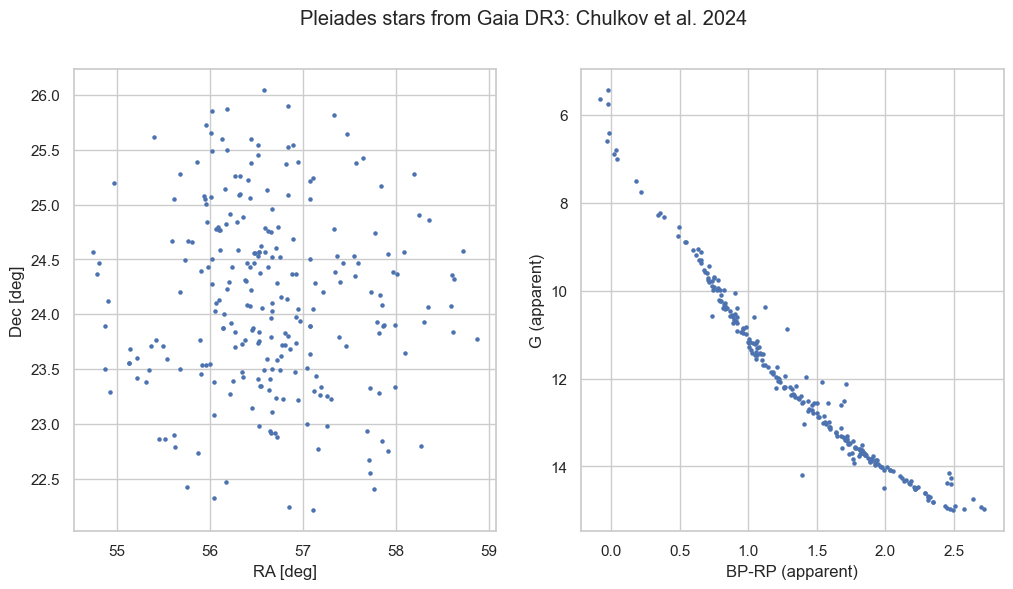

In [6]:
plotPath = "plots/Wide_Binaries/"
if not os.path.exists(plotPath):
    os.makedirs(plotPath)

## Check plot:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Pleiades stars from Gaia DR3: Chulkov et al. 2024")
ax[0].scatter(df["ra"], df["dec"], s=5)
ax[0].set_xlabel("RA [deg]")
ax[0].set_ylabel("Dec [deg]")

ax[1].scatter(df["bp_rp"], df["phot_g_mean_mag"], s=5)
ax[1].set_ylabel("G (apparent)")
ax[1].set_xlabel("BP-RP (apparent)")
ax[1].invert_yaxis()

if save:
    fig.savefig(plotPath+"Pleiades_Gaia_DR3_Chulkov_et_al_2024.png", dpi=300)

### Calculating Mass 

In [7]:
## ISOCHRONE

# Read the first few lines to inspect structure
iso_data = 'DATA/output69089225567.dat'                 #output69089225567.dat is the one where a put an Av = 0.15 as the paper suggests
with open(iso_data, "r") as f:
    lines = f.readlines()

# Show the first 20 lines to understand header and column structure
lines[:20]

['# File generated by CMD 3.8 (http://stev.oapd.inaf.it/cmd) on Wed May 21 17:25:42 UTC 2025\n',
 '# isochrones based on PARSEC release v2.0 \n',
 '# Basic references: Costa et al. 2019a,2019b for the code, Nguyen et al. 2022 for the tracks.\n',
 '# Rotating tracks computed with omega_i=0.00, except for lower masses (see paper)\n',
 '# Thermal pulse cycles included \n',
 '# On RGB, assumed Reimers mass loss with efficiency eta=0.2\n',
 '# LPV periods and growth rates added cf. Trabucchi et al. (2019)\n',
 '# but fundamental-mode LPV periods + transition are from Trabucchi et al. (2021)\n',
 '# Photometric system: Gaia EDR3 (all Vegamags, Gaia passbands from ESA/Gaia website)\n',
 "# Attention: photometry includes extinction of Av=0.15, with coefficients derived star-by-star, for Cardelli et al 89 + O'Donnell 94 Rv=3.1 extinction curve.\n",
 '# Using YBC version of bolometric corrections as in Chen et al. (2019)\n',
 '# O-rich circumstellar dust ignored\n',
 '# C-rich circumstellar dust

In [8]:
# Find the header line (starts with "# Zini")
header_line_index = next(i for i, line in enumerate(lines) if line.startswith('# Zini'))

# Extract column names from the header line
column_names = lines[header_line_index].lstrip("#").strip().split()

# Read the data from the file using pandas, skipping the header lines
isochrone_df = pd.read_csv(
    iso_data,
    delim_whitespace=True,
    comment="#",
    names=column_names
)

# Select relevant CMD columns
iso_cmd_df = isochrone_df[["Mass", "G_BP_fSBmag", "G_fSBmag", "G_RP_fSBmag"]]
iso_cmd_df.head()

,Mass,G_BP_fSBmag,G_fSBmag,G_RP_fSBmag
0,0.090,16.719,13.868,12.353
1,0.096,16.593,13.740,12.225
2,0.100,16.475,13.645,12.135
3,0.106,16.289,13.509,12.007
4,0.114,15.915,13.262,11.783


C:\Users\bosca\AppData\Local\Temp\ipykernel_18032\2856367970.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_cmd_df["BP-RP fSBmag"] = iso_cmd_df["G_BP_fSBmag"].values - iso_cmd_df["G_RP_fSBmag"].values


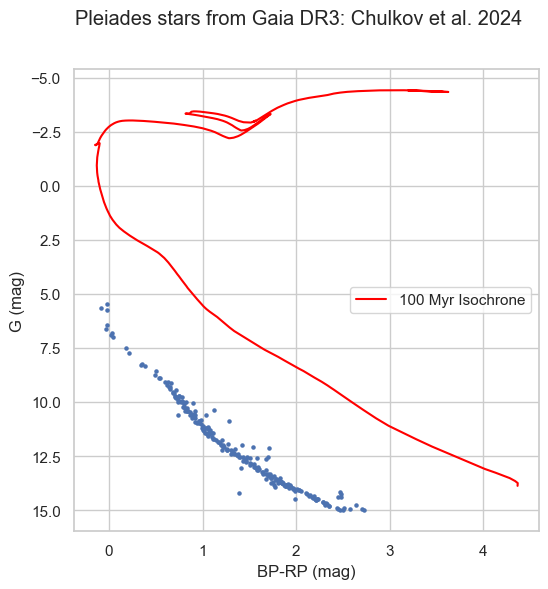

In [9]:
## plot against the data:

iso_cmd_df["BP-RP fSBmag"] = iso_cmd_df["G_BP_fSBmag"].values - iso_cmd_df["G_RP_fSBmag"].values
color_iso = iso_cmd_df["BP-RP fSBmag"].values
mag_iso = iso_cmd_df["G_fSBmag"]

fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Pleiades stars from Gaia DR3: Chulkov et al. 2024")

ax.scatter(df["bp_rp"], df["phot_g_mean_mag"], s=5)
ax.plot(color_iso, mag_iso, color='red', label='100 Myr Isochrone')
ax.set_ylabel("G (mag)")
ax.set_xlabel("BP-RP (mag)")
ax.invert_yaxis()
ax.legend(loc='center right')

In [10]:
# Extinction in Gaia bands (using Casagrande+ 2021, typical for AV = 0.15):

mu = 5.65                   # distance modulus for 135 pc
A_V = 0.15                  # extinction in V band
A_G = 0.789 * A_V           # extinction in G band
A_BP = 1.067 * A_V          # extinction in BP band
A_RP = 0.634 * A_V          # extinction in RP band

# Correct the magnitudes
iso_cmd_df["CORR G_fSBmag"] = iso_cmd_df["G_fSBmag"] + mu + A_G
iso_cmd_df["CORR G_BP_fSBmag"] = iso_cmd_df["G_BP_fSBmag"] + mu + A_BP
iso_cmd_df["CORR G_RP_fSBmag"] = iso_cmd_df["G_RP_fSBmag"] + mu + A_RP
iso_cmd_df['CORR BP-RP fSBmag'] = iso_cmd_df["CORR G_BP_fSBmag"].values - iso_cmd_df["CORR G_RP_fSBmag"].values

# isochrone cuts for pleiades stars

iso_pleiades = iso_cmd_df[
    (iso_cmd_df["CORR G_fSBmag"] < 16.0) &
    (iso_cmd_df["CORR G_fSBmag"] > 3.8) &
    (iso_cmd_df["CORR BP-RP fSBmag"] < 5.0) &
    (iso_cmd_df["CORR BP-RP fSBmag"] > - 0.5)
].copy()


C:\Users\bosca\AppData\Local\Temp\ipykernel_18032\3644795417.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_cmd_df["CORR G_fSBmag"] = iso_cmd_df["G_fSBmag"] + mu + A_G
C:\Users\bosca\AppData\Local\Temp\ipykernel_18032\3644795417.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_cmd_df["CORR G_BP_fSBmag"] = iso_cmd_df["G_BP_fSBmag"] + mu + A_BP
C:\Users\bosca\AppData\Local\Temp\ipykernel_18032\3644795417.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

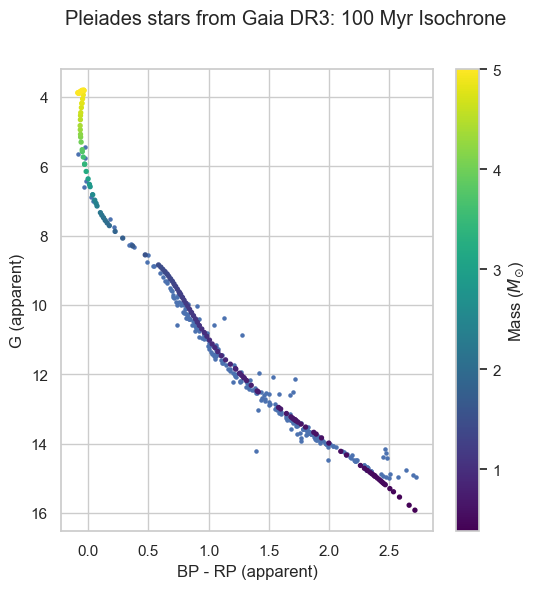

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Pleiades stars from Gaia DR3: 100 Myr Isochrone")

ax.scatter(df['bp_rp'], df["phot_g_mean_mag"], s=5)
sc = ax.scatter(iso_pleiades['CORR BP-RP fSBmag'], iso_pleiades["CORR G_fSBmag"].values, c=iso_pleiades["Mass"], cmap='viridis', s=8, label='Isochrone (100 Myr)')
ax.set_xlabel("BP - RP (apparent)")
ax.set_ylabel("G (apparent)")
ax.invert_yaxis()
legend = ax.legend(loc='upper right')
legend.remove()  # Remove legend for scatter, as colorbar is more informative

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(r"Mass ($M_{\odot}$)")

if save:
    fig.savefig(plotPath+"Pleiades_Gaia_DR3_Chulkov_et_al_2024_isochrone.png", dpi=300)

In [12]:
## good, now we assigne the mass from the isochrone for each stars in Gaia dataframe

def assign_mass(row, iso_df):
    # Find the closest mass in the isochrone data
    closest_mass = iso_df.iloc[(iso_df['CORR BP-RP fSBmag'] - row['bp_rp']).abs().argsort()[:1]]['Mass'].values[0]
    return closest_mass

df['Mass (M_sun)'] = df.apply(lambda row: assign_mass(row, iso_pleiades), axis=1)
print(f"Number of stars in the Pleiades with radial velocity and mass: {len(df)}")

Number of stars in the Pleiades with radial velocity and mass: 251


In [13]:
df.head(20)

,source_id,ra,dec,ra_error,dec_error,ra_dec_corr,parallax,parallax_error,pmra,pmra_error,...,bp_rp,radial_velocity,radial_velocity_error,ipd_frac_multi_peak,ipd_gof_harmonic_amplitude,astrometric_chi2_al,astrometric_n_good_obs_al,ruwe,duplicated_source,Mass (M_sun)
0,65588484235454592,58.268967,22.801153,0.013425,0.008666,-0.124594,7.293433,0.014909,19.036700,0.017368,...,1.599491,6.250218,0.944959,0,0.025033,352.88670,329,1.044438,False,0.695
1,65673593307063552,57.816005,23.282072,0.018949,0.011151,-0.086201,7.391214,0.019583,20.266120,0.023781,...,2.054302,-1.554802,4.088157,0,0.036792,482.27945,447,1.075288,False,0.557
2,65677372878285312,57.714441,23.328869,0.014915,0.008545,0.050938,7.333805,0.016010,18.888363,0.017319,...,1.262271,6.402642,0.464261,0,0.043562,832.00635,419,1.130002,False,0.816
3,65680499614460800,57.989008,23.339221,0.014527,0.008449,0.101453,7.484240,0.014865,20.844311,0.018879,...,1.465252,5.429410,1.014421,0,0.024680,648.59180,418,1.072775,False,0.747
4,65712488530853120,58.093865,23.644663,0.016725,0.008423,-0.028021,7.842320,0.016345,20.351204,0.022248,...,1.828077,8.562927,2.124587,0,0.081661,390.80020,380,1.052246,False,0.614
5,65750627840192256,58.870949,23.772242,0.014308,0.008699,0.007505,7.250917,0.015259,17.759083,0.018394,...,1.735012,0.921870,2.339711,0,0.027942,462.76154,394,1.120992,False,0.634
6,65800930496992512,58.616589,23.835175,0.013759,0.008399,-0.044843,7.622050,0.014964,19.623070,0.017765,...,1.699927,2.231457,8.190568,0,0.021413,555.91156,357,1.091179,False,0.661
7,65819965792011904,58.590040,24.075488,0.014984,0.009328,0.142843,7.389536,0.015949,19.328267,0.019951,...,0.696617,5.178872,1.073765,0,0.057774,831.83997,402,0.992194,False,1.338
8,64006905476619776,56.846894,22.244354,0.017103,0.012655,0.218278,7.121283,0.019015,19.565234,0.021980,...,1.887485,1.151690,3.210027,0,0.027786,223.44173,238,1.008140,False,0.595
9,64009448097245440,57.106367,22.211391,0.014110,0.010894,0.083997,6.539304,0.016791,17.353896,0.017274,...,1.680802,55.502050,4.780878,0,0.041022,278.19070,271,1.050145,False,0.667


## From Wide Binaries paper

In [14]:
from itertools import combinations
from astropy.coordinates import SkyCoord
import astropy.units as u

# Step 1: Reload and recompute distance
df_WideBinary = df.copy()
df_WideBinary["distance_pc"] = 1000.0 / df_WideBinary["parallax"]

# Convert to SkyCoord for angular separation
coords = SkyCoord(ra=df_WideBinary["ra"].values * u.deg,
                  dec=df_WideBinary["dec"].values * u.deg,
                  distance=df_WideBinary["distance_pc"].values * u.pc)

# Step 2: Define constants
MAX_SEP_KAU = 50       # max projected separation in kAU
MAX_DELTA_V = 3.0      # km/s max velocity difference
MAX_DELTA_D = 8.0      # pc max distance difference
SIGMA_CUT = 4
G_km3_s2_Msun = 4.302e-3  # Gravitational constant in pc (km/s)^2 / M_sun

# Step 3: First pass to get all candidate binaries
initial_candidates = []

# Iterate over unique pairs
for i, j in combinations(range(len(df_WideBinary)), 2):
    star1, star2 = df_WideBinary.iloc[i], df_WideBinary.iloc[j]

    # Distance consistency checks
    d1, d2 = star1["distance_pc"], star2["distance_pc"]
    d_err1 = star1["parallax_error"] / (star1["parallax"]**2) * 1000
    d_err2 = star2["parallax_error"] / (star2["parallax"]**2) * 1000
    delta_d = abs(d1 - d2)

    if delta_d > MAX_DELTA_D:             #If the difference in distance is greater than 8 pc, skip this pair: that what continue mean inside the loop
        continue
    if delta_d > SIGMA_CUT * np.sqrt(d_err1**2 + d_err2**2):
        continue

    # Projected separation in kAU (apparent distance between the two stars as observed from Earth)
    ang_sep_rad = coords[i].separation(coords[j]).radian
    mean_d = 0.5 * (d1 + d2)
    proj_sep_kau = ang_sep_rad * mean_d * 206265 / 1000  #(kAU)   206265 is the number of arcseconds in a radian

    if proj_sep_kau > MAX_SEP_KAU:
        continue

    # Projected velocity difference
    d_pmra = star1["pmra"] - star2["pmra"]
    d_pmdec = star1["pmdec"] - star2["pmdec"]
    mu_diff = np.sqrt(d_pmra**2 + d_pmdec**2)  # mas/yr
    '''
    The constant 4.74047 is used to convert a proper motion (in mas/yr) and distance (in pc)
    into a tangential velocity in km/s. The formula is derived from the relationship:
    v (km/s) = 4.74047 x μ (mas/yr) x d (pc) / 1000
    dividing by 1000 converts the proper motion from milliarcseconds to arcseconds
    '''
    vp_kms = 4.74047 * mu_diff * mean_d / 1000  # km/s

    if vp_kms > MAX_DELTA_V:
        continue

    rv1, rv2 = star1['radial_velocity'], star2['radial_velocity']
    rv_diff = abs(rv1 - rv2)
    rv_err = np.sqrt(star1['radial_velocity_error']**2 + star2['radial_velocity_error']**2)

    if rv_diff > 3.0 or rv_diff > SIGMA_CUT * rv_err:
        continue

    # Circular velocity
    Mtot = star1["Mass (M_sun)"] + star2["Mass (M_sun)"]
    rp_pc = proj_sep_kau * 4.84814e-3                        #1 kAU is approximately equal to 0.00484814 parsecs
    vc_kms = np.sqrt(G_km3_s2_Msun * Mtot / rp_pc)
    v_ratio = vp_kms / vc_kms

    initial_candidates.append({
        "index_1": i,
        "index_2": j,
        "source_id_1": star1["source_id"],
        "source_id_2": star2["source_id"],
        "rp_kAU": proj_sep_kau,
        "vp_kms": vp_kms,
        "vc_kms": vc_kms,
        "v_ratio": v_ratio,
        "mass1": star1["Mass (M_sun)"],
        "mass2": star2["Mass (M_sun)"],
        "Mtot": Mtot,
        "distance1_pc": d1,
        "distance2_pc": d2
    })

# Step 4: Remove shared-star (triple system) cases
df_pairs = pd.DataFrame(initial_candidates)
all_stars = pd.concat([df_pairs["source_id_1"], df_pairs["source_id_2"]])
duplicate_ids = all_stars[all_stars.duplicated()].unique()
mask_triples = ~(
    df_pairs["source_id_1"].isin(duplicate_ids) |
    df_pairs["source_id_2"].isin(duplicate_ids)
)
deduped_pairs = df_pairs[mask_triples].reset_index(drop=True)

print(deduped_pairs.shape)
deduped_pairs.head()

(15, 13)


,index_1,index_2,source_id_1,source_id_2,rp_kAU,vp_kms,vc_kms,v_ratio,mass1,mass2,Mtot,distance1_pc,distance2_pc
0,27,31,69840879814047872,69863454162150656,24.014438,1.240099,0.234247,5.293974,1.105,0.380,1.485,134.623142,136.529593
1,34,35,69876712724339456,69877163697813248,23.573111,0.765523,0.235952,3.244406,0.893,0.586,1.479,134.491655,133.650260
2,62,95,64808204638390912,64899017426872960,16.905972,1.231325,0.366419,3.360429,1.395,1.163,2.558,139.809914,139.119162
3,64,65,66480944080770176,66481734354737792,34.569017,0.473008,0.194119,2.436696,0.834,0.634,1.468,136.388227,135.670414
4,76,77,66517468482370176,66517468482370304,1.767555,0.797801,0.947425,0.842073,0.586,1.202,1.788,137.078128,137.194366


In [15]:
# Step 5: Apply RUWE-like data quality cut (based on Arenou et al. 2018)
def compute_u(row):
    chi2 = row["astrometric_chi2_al"]
    n_good = row["astrometric_n_good_obs_al"]
    if n_good <= 5:
        return np.inf
    return np.sqrt(chi2 / (n_good - 5))

def quality_pass(row):
    G = row["phot_g_mean_mag"]
    u = compute_u(row)
    threshold = 1.2 * max(1, np.exp(-0.2 * (G - 19.5)))
    return u <= threshold  #return True or False

good_stars = df[["source_id", "phot_g_mean_mag", "astrometric_chi2_al", "astrometric_n_good_obs_al"]].copy()
good_stars["quality_pass"] = good_stars.apply(quality_pass, axis=1)
valid_ids = good_stars[good_stars["quality_pass"]]["source_id"].values

final_cleaned = deduped_pairs[
    deduped_pairs["source_id_1"].isin(valid_ids) &
    deduped_pairs["source_id_2"].isin(valid_ids)
].reset_index(drop=True)

print(f"total number of wide binary pairs found: {final_cleaned.shape[0]}")
final_cleaned.head()

total number of wide binary pairs found: 15


,index_1,index_2,source_id_1,source_id_2,rp_kAU,vp_kms,vc_kms,v_ratio,mass1,mass2,Mtot,distance1_pc,distance2_pc
0,27,31,69840879814047872,69863454162150656,24.014438,1.240099,0.234247,5.293974,1.105,0.380,1.485,134.623142,136.529593
1,34,35,69876712724339456,69877163697813248,23.573111,0.765523,0.235952,3.244406,0.893,0.586,1.479,134.491655,133.650260
2,62,95,64808204638390912,64899017426872960,16.905972,1.231325,0.366419,3.360429,1.395,1.163,2.558,139.809914,139.119162
3,64,65,66480944080770176,66481734354737792,34.569017,0.473008,0.194119,2.436696,0.834,0.634,1.468,136.388227,135.670414
4,76,77,66517468482370176,66517468482370304,1.767555,0.797801,0.947425,0.842073,0.586,1.202,1.788,137.078128,137.194366


In [16]:
from matplotlib import cm

# Generate 20 well-separated colors from the 'viridis' colormap
num_colors = len(final_cleaned)
colors = [cm.tab20(i / num_colors) for i in range(num_colors)]

# Example usage: print the colors
print(colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), (0.9686274509803922, 0.7137254901960784, 0.8235294117647058, 1.0), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), (0.8588235294117647, 0.8588235294117647, 0.5529411764705883, 1.0), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]


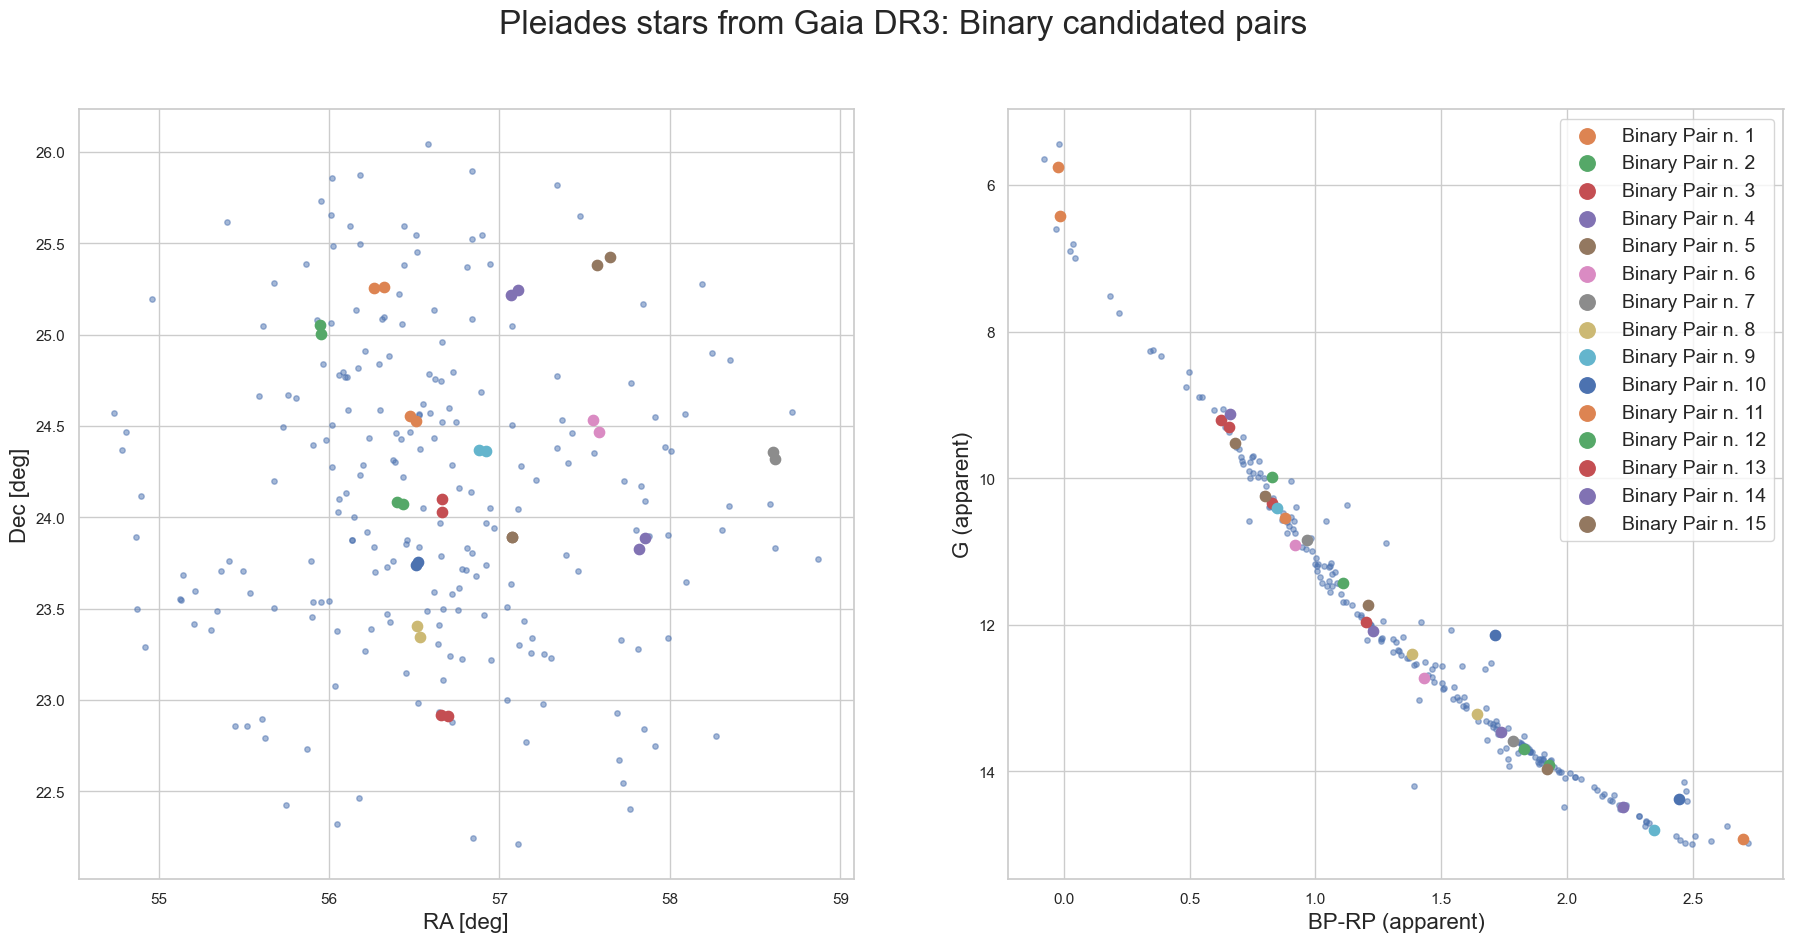

In [18]:
## Check plot:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))
fig.suptitle("Pleiades stars from Gaia DR3: Binary candidated pairs", fontsize=24)
ax[0].scatter(df["ra"], df["dec"], s=15, alpha=0.5)
for _, row in final_cleaned.iterrows():
    star1 = df[df["source_id"] == row["source_id_1"]].iloc[0]
    star2 = df[df["source_id"] == row["source_id_2"]].iloc[0]
    ax[0].scatter([star1['ra'], star2['ra']],
                  [star1['dec'], star2['dec']],
                  alpha=1.0, s=55)
ax[0].set_xlabel("RA [deg]", fontsize=16)
ax[0].set_ylabel("Dec [deg]", fontsize=16)

ax[1].scatter(df["bp_rp"], df["phot_g_mean_mag"], s=15, alpha=0.5)
for _, row in final_cleaned.iterrows():
    star1 = df[df["source_id"] == row["source_id_1"]].iloc[0]
    star2 = df[df["source_id"] == row["source_id_2"]].iloc[0]
    ax[1].scatter([star1['bp_rp'], star2['bp_rp']],
                  [star1['phot_g_mean_mag'], star2['phot_g_mean_mag']],
                  alpha=1.0, s=55, label='Binary Pair n. {}'.format(_+1))
ax[1].set_ylabel("G (apparent)", fontsize=16)
ax[1].set_xlabel("BP-RP (apparent)", fontsize=16)
ax[1].invert_yaxis()
ax[1].legend(loc='upper right', fontsize=14, markerscale=1.5)


if save:
    final_cleaned.to_csv("DATA/Wide_Binaries/Pleiades_Wide_Binary_Candidates.csv", index=False)
    fig.savefig(plotPath+"Pleiades_Wide_Binary_Candidates.png", dpi=300)


In [19]:
# Dividing into two dataframes: one with pairs from Chulkov et al. 2024 and one with the rest
primary_members_df = df[df['source_id'].isin(final_cleaned['source_id_1'])].copy()
secondary_members_df = df[df['source_id'].isin(final_cleaned['source_id_2'])].copy()



# Step 1: Create an empty list to store the filtered rows
filtered_gaia_rows = []

# Step 2: Iterate over each Primary_Gaia_source_id and get the corresponding Gaia row
for primary_id in final_cleaned['source_id_1']:
    # Find the corresponding row in Gaia data for the given source_id
    row = primary_members_df[primary_members_df['source_id'] == primary_id]
    
    # Append the row to the filtered list
    filtered_gaia_rows.append(row)

# Step 3: Concatenate all the filtered rows back into a DataFrame
primary_members_df_sorted = pd.concat(filtered_gaia_rows, ignore_index=True)

# same for secondary members:
filtered_gaia_rows = []

for secondary_id in final_cleaned['source_id_2']:
    row = secondary_members_df[secondary_members_df['source_id'] == secondary_id]
    filtered_gaia_rows.append(row)

secondary_members_df_sorted = pd.concat(filtered_gaia_rows, ignore_index=True)



primary_members_df_sorted.reset_index(inplace=True, drop=True)
secondary_members_df_sorted.reset_index(inplace=True, drop=True)

print(primary_members_df_sorted.shape)
print(secondary_members_df_sorted.shape)

(15, 25)
(15, 25)


In [21]:
primary_members_df_sorted.head(15)

,source_id,ra,dec,ra_error,dec_error,ra_dec_corr,parallax,parallax_error,pmra,pmra_error,...,bp_rp,radial_velocity,radial_velocity_error,ipd_frac_multi_peak,ipd_gof_harmonic_amplitude,astrometric_chi2_al,astrometric_n_good_obs_al,ruwe,duplicated_source,Mass (M_sun)
0,69840879814047872,56.266813,25.257647,0.016349,0.012347,0.075467,7.428143,0.020095,18.647570,0.019928,...,0.880663,5.076045,0.328219,0,0.032434,643.26650,235,1.148958,False,1.105
1,69876712724339456,55.951482,25.004185,0.023082,0.015187,-0.106823,7.435406,0.022914,19.859673,0.031726,...,1.108473,9.293303,6.716938,0,0.063614,749.45526,183,1.113729,False,0.893
2,64808204638390912,56.660064,22.919584,0.017756,0.014186,0.253192,7.152569,0.020364,19.924153,0.022785,...,0.657387,6.324677,0.444220,0,0.035761,416.20917,187,1.037334,False,1.395
3,66480944080770176,57.820371,23.826400,0.016239,0.009507,0.145891,7.332011,0.017303,19.840059,0.021189,...,1.230754,5.824165,0.819238,0,0.035241,921.65860,401,1.169364,False,0.834
4,66517468482370176,57.075122,23.891274,0.020812,0.014940,-0.009620,7.295110,0.021686,19.104444,0.026129,...,1.921240,8.476849,2.436734,0,0.024625,270.69955,238,1.109031,False,0.586
5,66565365957676416,57.587208,24.466545,0.020498,0.015692,0.288885,7.247914,0.023267,20.345936,0.027922,...,0.919638,5.401723,0.401106,0,0.074447,1301.97560,354,1.230575,False,1.048
6,66581549393480704,58.618642,24.320930,0.016028,0.009066,0.038893,7.419622,0.015880,18.822255,0.020378,...,1.786049,7.117577,1.938180,0,0.044531,389.44595,401,1.020911,False,0.614
7,64971933089093760,56.534934,23.347321,0.014513,0.010024,0.023770,7.388568,0.015052,19.542916,0.018825,...,1.640963,6.731614,3.053031,0,0.039066,206.43590,209,1.023201,False,0.680
8,66737095928811648,56.918617,24.364356,0.019852,0.013987,0.192200,7.396119,0.021420,19.316595,0.025703,...,0.846984,5.542121,0.478626,0,0.018742,383.20100,158,1.023037,False,1.144
9,65201039527567232,56.511596,23.737182,0.014211,0.010304,0.109013,7.425796,0.016195,19.495712,0.016962,...,1.713054,5.877510,0.541752,0,0.060164,417.47128,240,1.095474,False,0.650


In [22]:
if save:
    primary_members_df_sorted.to_csv("DATA/Wide_Binaries/Pleiades_Primary_Members.csv", index=False)
    secondary_members_df_sorted.to_csv("DATA/Wide_Binaries/Pleiades_Secondary_Members.csv", index=False)